In [8]:
import pandas as pd
from datetime import datetime, date, time, timezone, timedelta

In [9]:
from gurobipy import GRB, Model
import numpy as np

# Aufgabe 3 (i)

## Data Prep

### Einlesen des Forecasts für die WInderzeugung

In [10]:
df_forecast_wind = pd.read_csv('Wind_Forecast.csv', skiprows=3)

In [11]:
# remove empty rows
df_forecast_wind = df_forecast_wind[df_forecast_wind["electricity"].isnull() == False]

In [12]:
# remove empty columns
df_forecast_wind = df_forecast_wind.drop(df_forecast_wind.columns[3:14], axis=1)

In [13]:
# add Datetime index
date = []
for index, rows in df_forecast_wind.iterrows():
    date.append(datetime.strptime(rows["time"], "%d.%m.%Y %H:%M"))
    
df_forecast_wind['Datetime'] = date
df_forecast_wind = df_forecast_wind.set_index('Datetime')

In [14]:
df_forecast_wind

,time,local_time,electricity
Datetime,,,
2019-09-01 00:00:00,01.09.2019 00:00,01.09.2019 02:00,2.535175
2019-09-01 01:00:00,01.09.2019 01:00,01.09.2019 03:00,2.335636
2019-09-01 02:00:00,01.09.2019 02:00,01.09.2019 04:00,3.535083
2019-09-01 03:00:00,01.09.2019 03:00,01.09.2019 05:00,2.693114
2019-09-01 04:00:00,01.09.2019 04:00,01.09.2019 06:00,2.203940
...,...,...,...
2019-09-30 19:00:00,30.09.2019 19:00,30.09.2019 21:00,1.876225
2019-09-30 20:00:00,30.09.2019 20:00,30.09.2019 22:00,2.418040
2019-09-30 21:00:00,30.09.2019 21:00,30.09.2019 23:00,2.561387


In [15]:
# add relevant column to DataFrame
data = pd.DataFrame()
data['Forecast wind generation [kWh]'] = df_forecast_wind['electricity']

## Einlesen der Day-Ahead-Marktpreise

In [16]:
df_day_ahead_prices = pd.read_csv('Gro_handelspreise_201901010000_201912312359_Stunde.csv', sep=';', decimal=',')

In [17]:
# add datetime index
date_time = []
for index, rows in df_day_ahead_prices.iterrows():
    date = datetime.strptime(rows["Datum"], "%d.%m.%Y")
    time = datetime.strptime(str(rows["Anfang"]), "%H:%M").time()
    date_time.append(datetime.combine(date,time))
    
df_day_ahead_prices['Datetime'] = date_time
df_day_ahead_prices = df_day_ahead_prices.set_index('Datetime')

In [18]:
# slice September data
df_day_ahead_prices = df_day_ahead_prices['2019-09-01 00:00:00':'2019-09-30 23:00:00']
df_day_ahead_prices

,Datum,Anfang,Ende,Deutschland/Luxemburg [€/MWh] Originalauflösungen,∅ Anrainer DE/LU [€/MWh] Originalauflösungen,Belgien [€/MWh] Originalauflösungen,Dänemark 1 [€/MWh] Originalauflösungen,Dänemark 2 [€/MWh] Originalauflösungen,Frankreich [€/MWh] Originalauflösungen,Niederlande [€/MWh] Originalauflösungen,Norwegen 2 [€/MWh] Originalauflösungen,Österreich [€/MWh] Originalauflösungen,Polen [€/MWh] Originalauflösungen,Schweden 4 [€/MWh] Originalauflösungen,Schweiz [€/MWh] Originalauflösungen,Tschechien [€/MWh] Originalauflösungen,DE/AT/LU [€/MWh] Originalauflösungen,Italien (Nord) [€/MWh] Originalauflösungen,Slowenien [€/MWh] Originalauflösungen,Ungarn [€/MWh] Originalauflösungen
Datetime,,,,,,,,,,,,,,,,,,,,
2019-09-01 00:00:00,01.09.2019,00:00,01:00,27.20,-,27.20,27.20,28.75,27.20,27.20,28.75,27.20,-,28.75,30.86,"30,43",-,48.18,65.89,"65,19"
2019-09-01 01:00:00,01.09.2019,01:00,02:00,26.70,-,26.70,26.70,27.36,26.70,26.70,27.36,26.70,-,27.36,28.65,"28,5",-,44.41,51.50,"51,09"
2019-09-01 02:00:00,01.09.2019,02:00,03:00,26.47,-,26.47,26.47,26.47,26.47,26.47,26.47,26.47,-,26.47,27.39,"27,3",-,44.17,51.50,"48,05"
2019-09-01 03:00:00,01.09.2019,03:00,04:00,25.92,-,25.78,26.55,26.55,25.86,25.93,26.55,25.92,-,26.55,26.58,"27,4",-,42.00,42.00,"45,62"
2019-09-01 04:00:00,01.09.2019,04:00,05:00,25.29,-,24.80,25.91,25.91,25.06,25.34,25.91,25.29,-,25.91,26.25,"27,12",-,45.00,45.00,"41,29"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30 19:00:00,30.09.2019,19:00,20:00,64.37,-,64.37,35.13,35.13,64.37,64.37,35.13,64.37,-,35.13,54.24,55,-,77.73,84.99,"89,5"
2019-09-30 20:00:00,30.09.2019,20:00,21:00,57.34,-,57.34,35.03,35.03,57.34,57.34,35.03,57.34,-,35.03,52.93,51,-,70.94,70.94,"73,02"
2019-09-30 21:00:00,30.09.2019,21:00,22:00,49.27,-,49.27,34.38,34.38,49.27,49.27,34.38,49.27,-,34.38,46.64,"43,8",-,65.00,65.00,"63,1"


In [19]:
# convert unit to EUR / kWh and add relevant column to DataFrame
data['Day-ahead price [€/kWh]'] = (1/1000) * df_day_ahead_prices['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] # EUR / kWh
data

,Forecast wind generation [kWh],Day-ahead price [€/kWh]
Datetime,,
2019-09-01 00:00:00,2.535175,0.02720
2019-09-01 01:00:00,2.335636,0.02670
2019-09-01 02:00:00,3.535083,0.02647
2019-09-01 03:00:00,2.693114,0.02592
2019-09-01 04:00:00,2.203940,0.02529
...,...,...
2019-09-30 19:00:00,1.876225,0.06437
2019-09-30 20:00:00,2.418040,0.05734
2019-09-30 21:00:00,2.561387,0.04927


In [20]:
data

,Forecast wind generation [kWh],Day-ahead price [€/kWh]
Datetime,,
2019-09-01 00:00:00,2.535175,0.02720
2019-09-01 01:00:00,2.335636,0.02670
2019-09-01 02:00:00,3.535083,0.02647
2019-09-01 03:00:00,2.693114,0.02592
2019-09-01 04:00:00,2.203940,0.02529
...,...,...
2019-09-30 19:00:00,1.876225,0.06437
2019-09-30 20:00:00,2.418040,0.05734
2019-09-30 21:00:00,2.561387,0.04927


## Optimierung des Fahrplans: Speichereinsatz  + Verkäufe auf dem Day-Ahead-Markt

In [21]:
# given parameters
timesteps = range(24) # hours
storage_capacity = 15 # kWh
power = 5 # kW

Die folgende Funktion errechnet den optimalen Fahrplan eines Tages (24h) bei gegebener Winderzeugung (Forecast) und Speicherstand.

In [22]:
def optimize_next_day(day_data, battery_status):
    
    wind_generation = day_data['Forecast wind generation [kWh]']
    energy_prices = (1/1000) * day_data['Day-ahead price [€/kWh]']

    # initialize model
    wind_model = Model('Wind power profit maximization')

    # define variables
    stored_energy = wind_model.addVars([t for t in list(timesteps)+[24]], lb=0)
    energy_sold = wind_model.addVars([t for t in timesteps], lb=0)

    # (1) storage level at the beginning is given
    wind_model.addConstr(stored_energy[0] == battery_status)

    # (2) storage capacity is limited
    for t in timesteps:
        wind_model.addConstr(stored_energy[t+1] <= storage_capacity)
    
    for t in timesteps:
        # (3) power is limited
        wind_model.addConstr(stored_energy[t+1] <= stored_energy[t] + power)
        wind_model.addConstr(stored_energy[t+1] >= stored_energy[t] - power)

        # (4) the energy sold on the market is dependent on storage and generation
        # wind_model.addConstr(energy_sold[t] == wind_generation[t] + stored_energy[t] - stored_energy[t+1])
        wind_model.addConstr(energy_sold[t] + stored_energy[t+1] == wind_generation[t] + stored_energy[t] )

    # (5) In the last time step, the stored energy is sold (limited by power)
    wind_model.addConstr(energy_sold[timesteps[-1]] <= wind_generation[timesteps[-1]] + power)
    wind_model.addConstr(energy_sold[timesteps[-1]] <= wind_generation[timesteps[-1]] + stored_energy[t])

    # set objective function
    revenue = sum([energy_sold[t] * energy_prices[t] for t in timesteps]) # EUR
    wind_model.setObjective(revenue, GRB.MAXIMIZE)

    # solve
    wind_model.Params.LogToConsole = 0
    wind_model.optimize()
    
    # saving output in dictionary day by day
    output = pd.DataFrame()
    #output['Energy generated'] = wind_generation
    output['Energy sold on day-ahead market'] = [v.X for v in energy_sold.values()]
    energy_storage = list(stored_energy.values())
    output['Storage level (day-ahead schedule)'] = [v.X for v in energy_storage[1:]]
    output['Energy added to storage (day-ahead schedule)'] = [energy_storage[i+1].X - energy_storage[i].X for i in timesteps]
    
    return output

# Aufgabe 3 (ii)

## Data Prep

### Einlesen der realen Winderzeugung

In [23]:
df_real_wind = pd.read_csv('Wind_real.csv', skiprows=3)

In [24]:
# remove empty rows
df_real_wind = df_real_wind[df_real_wind["electricity"].isnull() == False]

In [25]:
# add Datetime index
date = []
for index, rows in df_real_wind.iterrows():
    date.append(datetime.strptime(rows["time"], "%d.%m.%Y %H:%M"))
    
df_real_wind["Datetime"] = date
df_real_wind.set_index('Datetime', inplace=True)

In [26]:
# add relevant column to DataFrame
data['Real wind generation [kWh]'] = df_real_wind['electricity']
data

,Forecast wind generation [kWh],Day-ahead price [€/kWh],Real wind generation [kWh]
Datetime,,,
2019-09-01 00:00:00,2.535175,0.02720,3.000
2019-09-01 01:00:00,2.335636,0.02670,2.988
2019-09-01 02:00:00,3.535083,0.02647,2.855
2019-09-01 03:00:00,2.693114,0.02592,2.666
2019-09-01 04:00:00,2.203940,0.02529,2.453
...,...,...,...
2019-09-30 19:00:00,1.876225,0.06437,1.864
2019-09-30 20:00:00,2.418040,0.05734,2.010
2019-09-30 21:00:00,2.561387,0.04927,2.360


### Einlesen der Intraday Preise

In [27]:
df_intraday_prices = pd.read_csv('Preise_Intraday.csv', skiprows=1)
df_intraday_prices

,Delivery day,Hour from,Hour to,ID3-Price
0,30.09.2019,24.0,24.0,27.15
1,30.09.2019,23.0,23.0,37.87
2,30.09.2019,22.0,22.0,42.44
3,30.09.2019,21.0,21.0,47.60
4,30.09.2019,20.0,20.0,56.38
...,...,...,...,...
41348,NaN,NaN,NaN,NaN
41349,NaN,NaN,NaN,NaN
41350,NaN,NaN,NaN,NaN
41351,NaN,NaN,NaN,NaN


In [28]:
# remove empty rows
df_intraday_prices = df_intraday_prices[df_intraday_prices["ID3-Price"].isnull() == False]

In [29]:
# adjust the 'hour from' column to define hourly intervals
df_intraday_prices["Hour from"] = df_intraday_prices["Hour from"].apply(lambda x: x-1)
df_intraday_prices

C:\Users\debbi\AppData\Local\Temp\ipykernel_5944\1725572602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intraday_prices["Hour from"] = df_intraday_prices["Hour from"].apply(lambda x: x-1)


,Delivery day,Hour from,Hour to,ID3-Price
0,30.09.2019,23.0,24.0,27.15
1,30.09.2019,22.0,23.0,37.87
2,30.09.2019,21.0,22.0,42.44
3,30.09.2019,20.0,21.0,47.60
4,30.09.2019,19.0,20.0,56.38
...,...,...,...,...
715,01.09.2019,4.0,5.0,25.67
716,01.09.2019,3.0,4.0,22.36
717,01.09.2019,2.0,3.0,20.52
718,01.09.2019,1.0,2.0,21.25


In [30]:
# add Datetime index
date_time = []
for index, rows in df_intraday_prices.iterrows():
    date = datetime.strptime(rows["Delivery day"], "%d.%m.%Y")
    time = datetime.strptime(str(int(rows["Hour from"])), "%H").time()
    date_time.append(datetime.combine(date,time))
    
df_intraday_prices["Datetime"] = date_time
df_intraday_prices = df_intraday_prices.set_index('Datetime')

C:\Users\debbi\AppData\Local\Temp\ipykernel_5944\758421333.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intraday_prices["Datetime"] = date_time


In [31]:
# convert Intraday price unit and add to DataFrame
data['Intraday price [€/kWh]'] = df_intraday_prices['ID3-Price'] / 1000 # EUR/KWh
data

,Forecast wind generation [kWh],Day-ahead price [€/kWh],Real wind generation [kWh],Intraday price [€/kWh]
Datetime,,,,
2019-09-01 00:00:00,2.535175,0.02720,3.000,0.02055
2019-09-01 01:00:00,2.335636,0.02670,2.988,0.02125
2019-09-01 02:00:00,3.535083,0.02647,2.855,0.02052
2019-09-01 03:00:00,2.693114,0.02592,2.666,0.02236
2019-09-01 04:00:00,2.203940,0.02529,2.453,0.02567
...,...,...,...,...
2019-09-30 19:00:00,1.876225,0.06437,1.864,0.05638
2019-09-30 20:00:00,2.418040,0.05734,2.010,0.04760
2019-09-30 21:00:00,2.561387,0.04927,2.360,0.04244


## Anpassung an die reale Erzeugung

Die folgende Funktion passt den Fahrplan anhand dieser Heuristik an:
- Bei einem Erzeugungsüberschuss wird der Strom auf dem Intradaymarkt verkauft, wenn der Preis dort überdurchschnittlich (bzgl. der vergangenen 24 h) hoch ist, ansonsten nach Möglichkeit eingespeichert.
- Bei einem Erzeugungsdefizit wird Strom vom Intradaymarkt eingekauft, wenn dieser günstig ist (niedriger Preis als im Mittel der letzten 24 h), ansonsten nach Möglichkeit aus dem Batteriespeicher entnommen.

Dabei werden alle technische Restriktionen beachtet (Batteriekapazität, max. (Ent-)Ladeleistung, State of Charge zum Zeitpunkt).

In [32]:
def get_actual_schedule(hour_data, optimal_schedule_hour, storage_level, mean_price):
    
    # Step 1) calculate energy surplus (deficit)
    energy_surplus = hour_data['Real wind generation [kWh]'] - hour_data['Forecast wind generation [kWh]']
    
    # Step 2) Decide if energy surplus should be sold on intraday market or stored in battery
    intraday_price = hour_data['Intraday price [€/kWh]']
    
    if energy_surplus > 0: # more generation than forecasted
        if intraday_price > mean_price:
            energy_sold_on_intraday_market = energy_surplus # sell energy because price is high
            energy_added_intraday = 0
        else:
            energy_sold_on_intraday_market = 0 # do not sell energy because price is low
            energy_added_intraday = energy_surplus # store energy surplus
            
    else: # energy deficit: less generation than forecasted
        if intraday_price > mean_price:
            energy_sold_on_intraday_market = 0 # do not BUY energy if price is high
            energy_added_intraday = energy_surplus # TAKE energy deficit from storage
        else:
            energy_sold_on_intraday_market = energy_surplus # buy energy because price is low
            energy_added_intraday = 0
            
    # Step 3) calculate the energy we would like to add to the storage (take from the storage)
    energy_added_day_ahead = optimal_schedule_hour['Energy added to storage (day-ahead schedule)']
    energy_added_plan = energy_added_day_ahead + energy_added_intraday
    
    
    # Step 4) Define technical restrictions (battery capacity, battery power) and adjust energy flow accordingly if necessary
    if energy_added_plan > 0: # if we plan to add energy to the storage
        technical_restriction = min(storage_capacity - storage_level, power)
        if energy_added_plan > technical_restriction:
            energy_sold_on_intraday_market = energy_sold_on_intraday_market + (energy_added_plan - technical_restriction)
            energy_added_actual = technical_restriction
        else:
            energy_added_actual = energy_added_plan
    
    else: # if we plan to take energy from the storage
        technical_restriction = -min(storage_level, power)
        if energy_added_plan < technical_restriction:
            energy_sold_on_intraday_market = energy_sold_on_intraday_market + (energy_added_plan - technical_restriction) # energy BOUGHT on intraday market
            energy_added_actual = technical_restriction
        else:
            energy_added_actual = energy_added_plan
    
    
    # Step 5) Update storage_level
    storage_level = storage_level + energy_added_actual
    
    return energy_sold_on_intraday_market, energy_added_actual, storage_level
    

In [33]:
output_per_day = {}
storage_level = 0

for day in range(30):
    print('Optimize day ', day, ' ...')
    
    # slice data of the respective day
    day_data = data[day*24:day*24 + 24]
    
    # get optimal schedule based on wind generation forecast
    optimal_schedule = optimize_next_day(day_data, battery_status=storage_level)
    output_per_day[day] = optimal_schedule
    
    energy_sold_list, energy_added_list, storage_level_list = [], [], []
        
    for hour in range(24):
        
        if day == 0:
            mean_price = sum(data['Intraday price [€/kWh]'])/720
        else:
            mean_price = data_last_24_hours['Intraday price [€/kWh]'][:-1].mean()
            
        data_last_24_hours = data.iloc[day*24 + hour - 24 : day*24 + hour, : ]
        mean_price = data_last_24_hours['Intraday price [€/kWh]'][:-1].mean()
        
        # slice respective hour from dataset
        hour_data = data.iloc[day*24 + hour, :]
        optimal_schedule_hour = optimal_schedule.iloc[hour]
        
        # get adapted schedule
        energy_sold_on_intraday_market, energy_added_to_storage, storage_level = get_actual_schedule(hour_data, optimal_schedule_hour, storage_level, mean_price)
        
        # store hourly results
        energy_sold_list.append(energy_sold_on_intraday_market)
        energy_added_list.append(energy_added_to_storage)
        storage_level_list.append(storage_level)
    
    # store daily results
    output_per_day[day]['Energy sold on intraday market'] = energy_sold_list
    output_per_day[day]['Energy added to storage (actual)'] = energy_added_list
    output_per_day[day]['Storage level (actual)'] = storage_level_list

Optimize day  0  ...
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-29
Optimize day  1  ...
Optimize day  2  ...
Optimize day  3  ...
Optimize day  4  ...
Optimize day  5  ...
Optimize day  6  ...
Optimize day  7  ...
Optimize day  8  ...
Optimize day  9  ...
Optimize day  10  ...
Optimize day  11  ...
Optimize day  12  ...
Optimize day  13  ...
Optimize day  14  ...
Optimize day  15  ...
Optimize day  16  ...
Optimize day  17  ...
Optimize day  18  ...
Optimize day  19  ...
Optimize day  20  ...
Optimize day  21  ...
Optimize day  22  ...
Optimize day  23  ...
Optimize day  24  ...
Optimize day  25  ...
Optimize day  26  ...
Optimize day  27  ...
Optimize day  28  ...
Optimize day  29  ...


In [34]:
# combine results to one DataFrame
df_outputs = pd.concat(list(output_per_day.values()))
df_outputs['Datetime'] = data.index
df_outputs = df_outputs.set_index('Datetime')
df_results = pd.concat([data, df_outputs], axis=1)

In [35]:
# check if sum of energy flows adds up
df_results['Check for correctness'] = np.isclose(df_results['Energy sold on intraday market'] + df_results['Energy added to storage (actual)'] + df_results['Energy sold on day-ahead market'], df_results['Real wind generation [kWh]'])
df_results

,Forecast wind generation [kWh],Day-ahead price [€/kWh],Real wind generation [kWh],Intraday price [€/kWh],Energy sold on day-ahead market,Storage level (day-ahead schedule),Energy added to storage (day-ahead schedule),Energy sold on intraday market,Energy added to storage (actual),Storage level (actual),Check for correctness
Datetime,,,,,,,,,,,
2019-09-01 00:00:00,2.535175,0.02720,3.000,0.02055,2.535175,0.000000,0.000000,0.000000,0.464825,0.464825,True
2019-09-01 01:00:00,2.335636,0.02670,2.988,0.02125,0.000000,2.335636,2.335636,0.000000,2.988000,3.452825,True
2019-09-01 02:00:00,3.535083,0.02647,2.855,0.02052,0.000000,5.870719,3.535083,-0.680083,3.535083,6.987908,True
2019-09-01 03:00:00,2.693114,0.02592,2.666,0.02236,0.000000,8.563833,2.693114,-0.027114,2.693114,9.681022,True
2019-09-01 04:00:00,2.203940,0.02529,2.453,0.02567,0.000000,10.767773,2.203940,0.000000,2.453000,12.134022,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30 19:00:00,1.876225,0.06437,1.864,0.05638,6.876225,5.000000,-5.000000,-0.012225,-5.000000,4.653128,True
2019-09-30 20:00:00,2.418040,0.05734,2.010,0.04760,7.418040,0.000000,-5.000000,-0.754912,-4.653128,0.000000,True
2019-09-30 21:00:00,2.561387,0.04927,2.360,0.04244,2.561387,0.000000,0.000000,-0.201387,-0.000000,0.000000,True


# Aufgabe 3 (iii)

In [36]:
df_results['Revenue on day-ahead market'] = df_results['Day-ahead price [€/kWh]'] * df_results['Energy sold on day-ahead market']
df_results['Revenue on intraday market'] = df_results['Intraday price [€/kWh]'] * df_results['Energy sold on intraday market']
df_results['Revenue (total)'] = df_results['Revenue on day-ahead market'] + df_results['Revenue on intraday market']

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

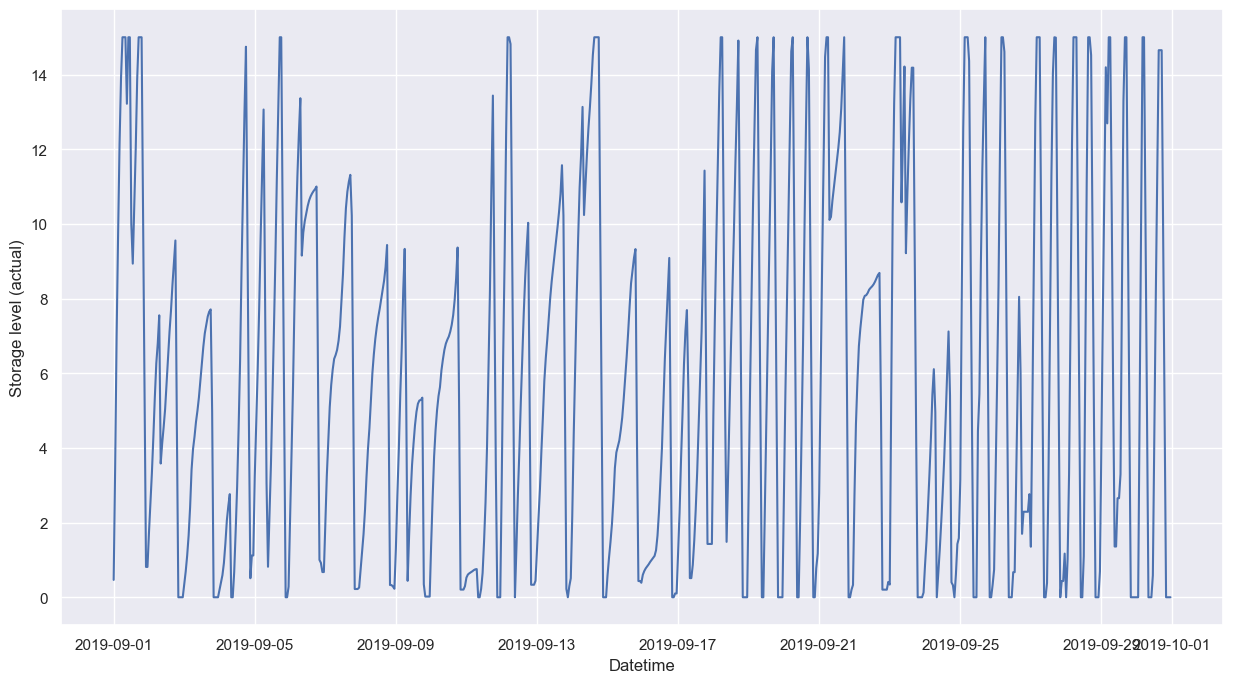

In [40]:
#Speicherstand
sns.lineplot(data=df_results,  x='Datetime', y='Storage level (actual)')

#set the size of the plot
sns.set(rc = {'figure.figsize':(15,8)})

#display final plot
plt.show()

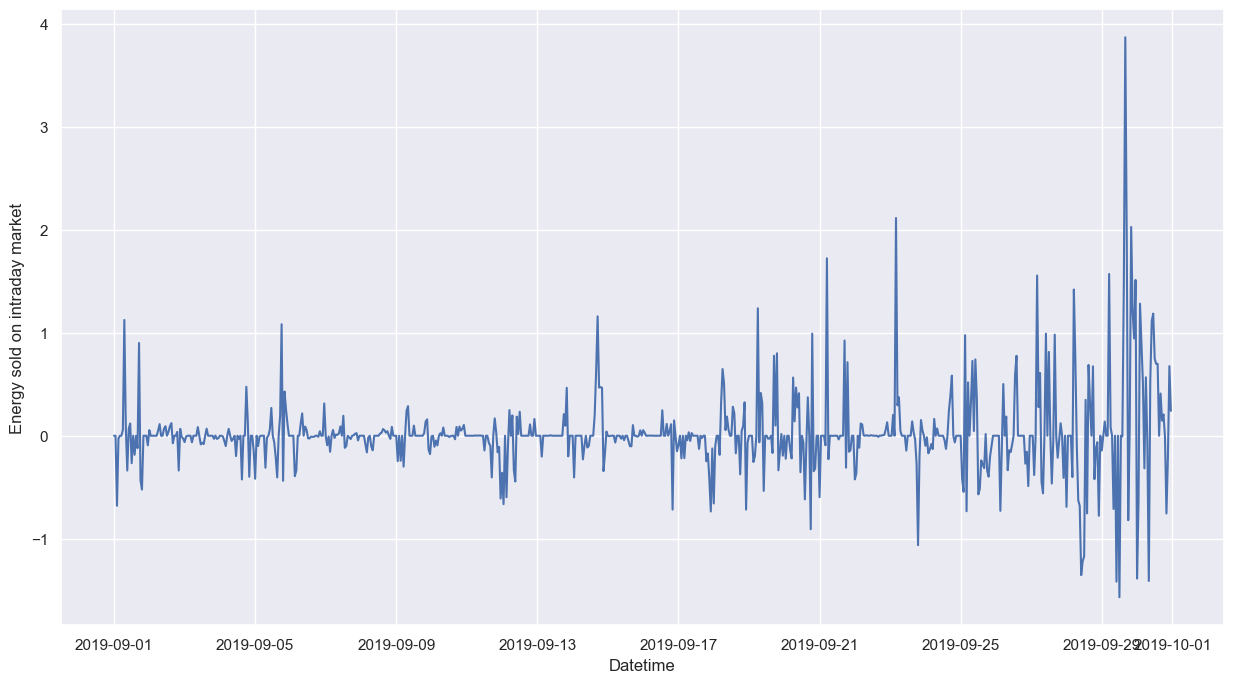

In [41]:
#Day-Ahead Market
sns.lineplot(data=df_results,  x='Datetime', y='Energy sold on intraday market')

#set the size of the plot
sns.set(rc = {'figure.figsize':(15,8)})

#display final plot
plt.show()

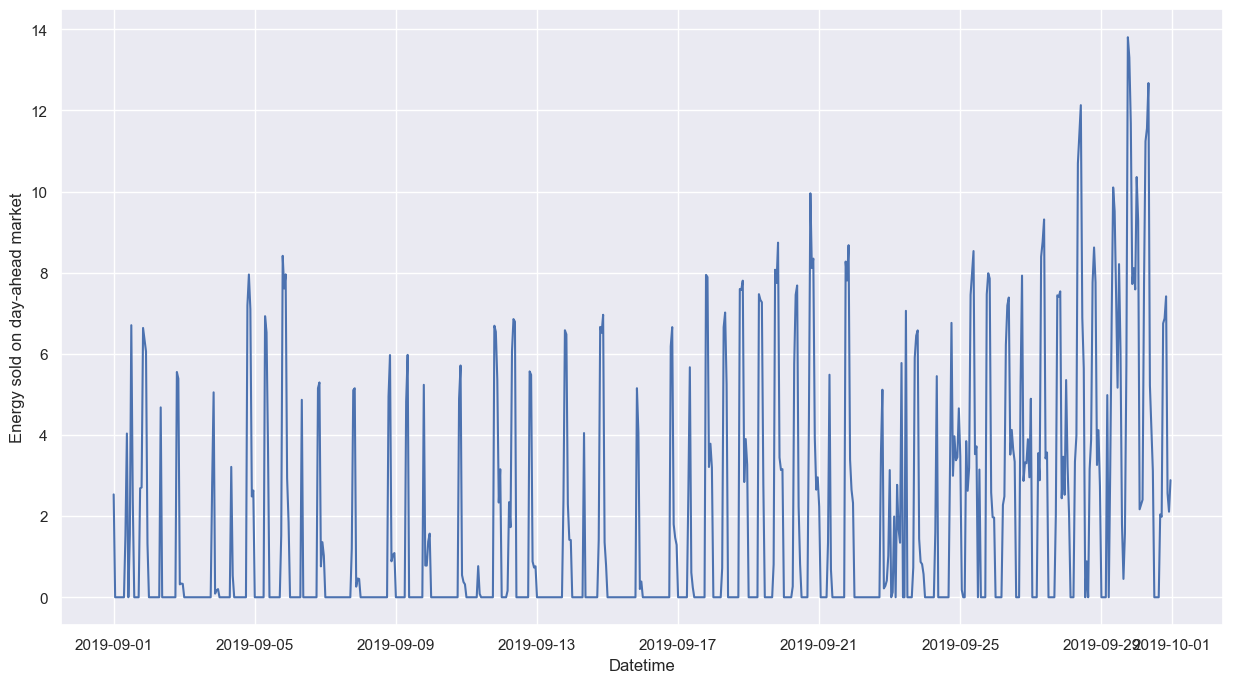

In [42]:
#Day-Ahead Market
sns.lineplot(data=df_results,  x='Datetime', y='Energy sold on day-ahead market')

#set the size of the plot
sns.set(rc = {'figure.figsize':(15,8)})

#display final plot
plt.show()

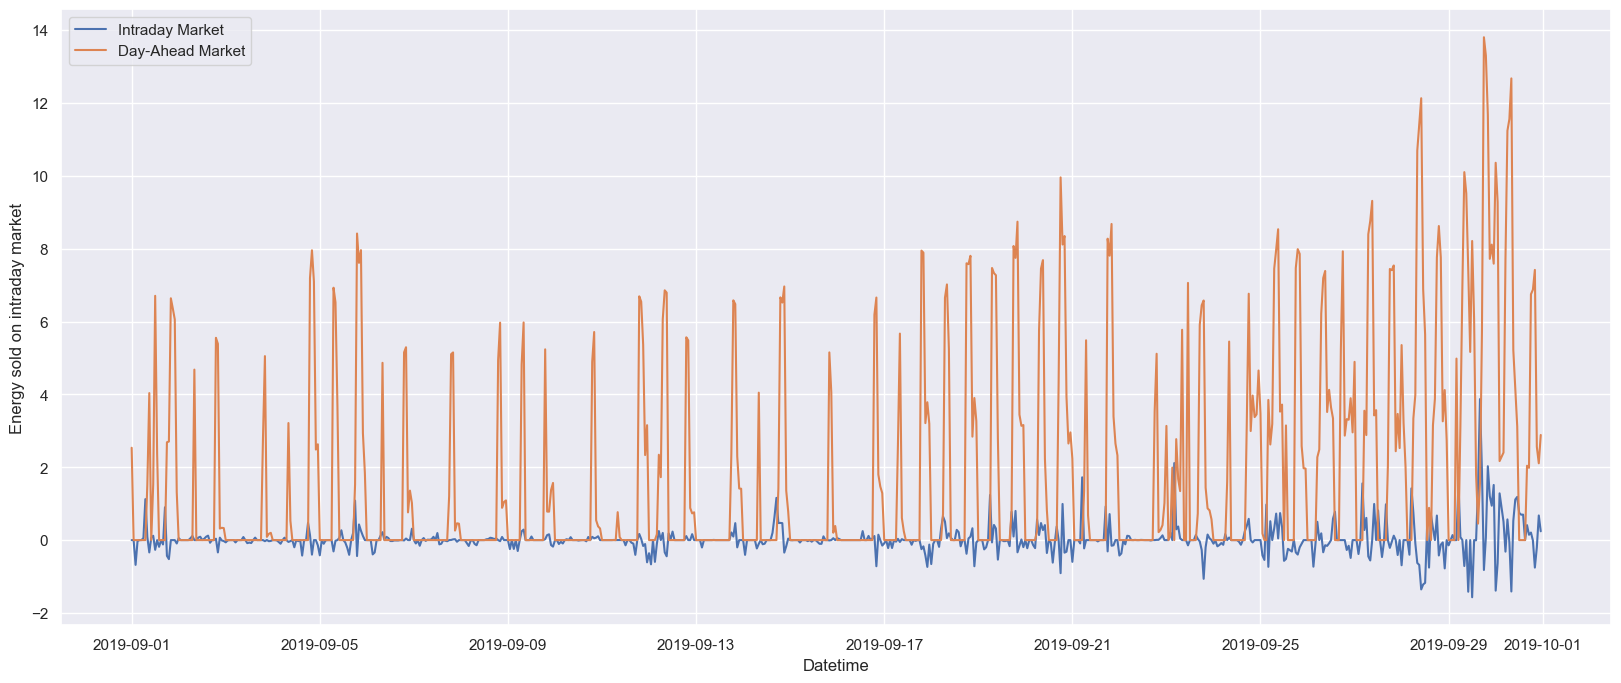

In [50]:
#Intraday Market
sns.lineplot(data=df_results,  x='Datetime', y='Energy sold on intraday market', label='Intraday Market')

#Day-Ahead Market
sns.lineplot(data=df_results,  x='Datetime', y='Energy sold on day-ahead market', label='Day-Ahead Market')

#set the size of the plot
sns.set(rc = {'figure.figsize':(15,8)})

#display final plot
plt.show()